# PYSPARK TUTORIAL

## we will be doing a classifcation algorithm problem is hwether a customer wil cimmit to a  term deposit .This  can be used to asssess  the credit risk of a customer.

In [38]:
import pyspark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.
 taget variable :deposit(Yes/No)

we will bes looking at the  first  five columns . we will be using  the pandas dataframe instead f the spark freame.show()

In [5]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


in the following we will be assessing the traget column variable where we will see if our target column is  balanced if not then we will need to balance the taget variable as our model would then be biased to a certain class

In [6]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


Here we will be looking at the summary statistics of our numeric columns . This comes in handy  when dealing with outliers and also looking at the distribution of the various columns.

In [7]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


Next we will be looking at the correlations of diffferent columns.This comes in handy when fitting the model where columns with lesser correlations are dropped. This is sililar to the pairplot that we  do  when  dealing with pandas.

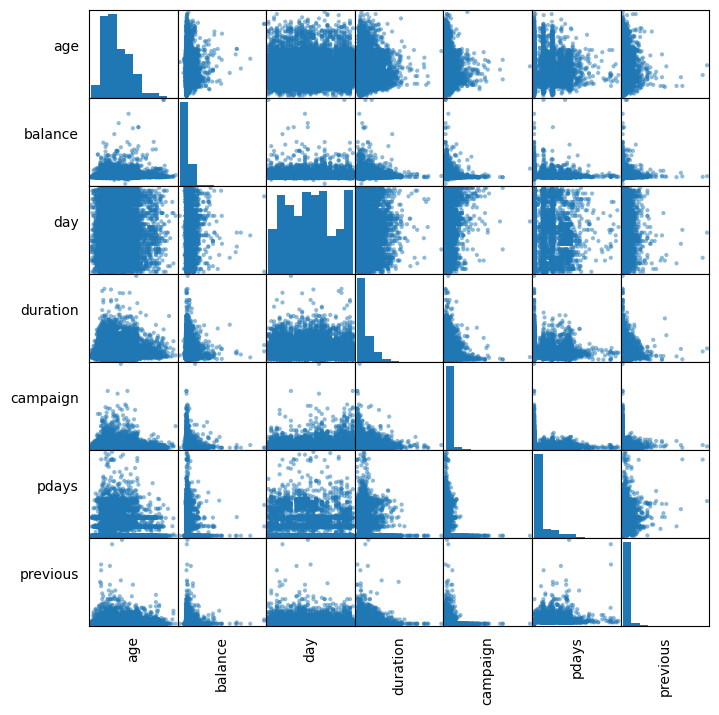

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

numeric_data = df.select(numeric_features).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8))

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')
        ax.set_yticks(())
        ax.xaxis.label.set_rotation(90)
        ax.set_xticks(())

plt.show()


We can see that there is not that concrete correlation between the columns above Therefore we can keeep all the variables for our modelexcept for the time (dayand month)basicallly  a month will not likely influemvce whether a deposit will be made or not

In [10]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



The data is clean there are no null values and if there were we would fill the missing values with the mode (when dealing with   categorical columns and when dealing with nueric columns we would use the median)

We will start with category indexing ,One Hot encoding and Vector Assembler-a feature transformer that merges multiple columns into a vector column
The code is available at the databricks site and it indexes each categorical columnusing the string Indexer and converts the indexed categories into one hot encoded varibales.
 The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

In [12]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Vector Assembler: A VectorAssembler is created to assemble all the feature columns, including the one-hot encoded categorical columns and the numeric columns, into a single feature vector named 'features'. The input columns are specified as assemblerInputs, which is a concatenation of the one-hot encoded categorical column names and the numeric column names. The VectorAssembler is added to the stages list.

The stages list will contain all the necessary stages of the data preprocessing pipeline, including string indexing, one-hot encoding, label string indexing, and vector assembling. These stages can then be used in a Pipeline for further processing or training a machine learning mod

we will then use a pipeline to chain multiple transformers and estimators together to specify our algorithm workflow

In [13]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



a Pipeline is created with the defined stages list. The Pipeline is used to chain together the stages of data preprocessing. Here's a brief explanation of the remaining code:

Creating a Pipeline: The Pipeline is instantiated with the stages list, which contains all the data preprocessing stages defined earlier.

Fitting the Pipeline: The pipeline.fit(df) call fits the Pipeline to the input dataframe df. This process applies each stage in the Pipeline to the data sequentially, transforming it according to the defined transformations.

Transforming the Data: The fitted Pipeline is then applied to the input dataframe df using pipelineModel.transform(df). This step executes the data transformations defined in the Pipeline and produces a new dataframe with the transformed features.

Selecting Columns: The selectedCols list is defined to specify the columns to be selected in the transformed dataframe. It includes the 'label' column, which represents the transformed target variable, the 'features' column, which contains the assembled feature vector, and cols, which likely refers to the remaining columns in the original dataframe.

Selecting Columns in the Transformed Dataframe: The df.select(selectedCols) operation is performed to select only the specified columns from the transformed dataframe. This operation creates a new dataframe with only the selected columns.

Printing the Schema: Finally, df.printSchema() is called to display the schema of the transformed dataframe. This provides information about the column names and their respective data types in the final transformed dataframe.

In [14]:
pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes


In [15]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


## Logistic Regression model

In [16]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Sorting Beta Coefficients: The beta coefficients from the linear regression model are sorted using np.sort()

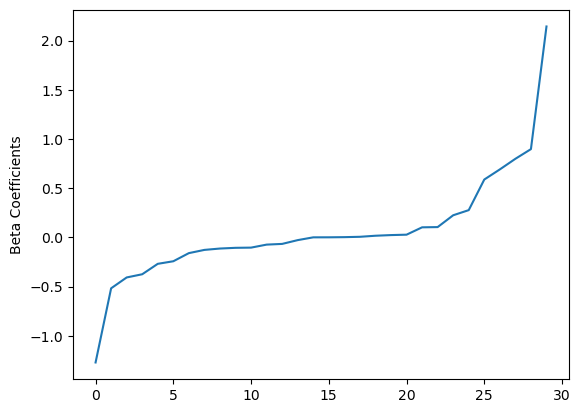

In [17]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

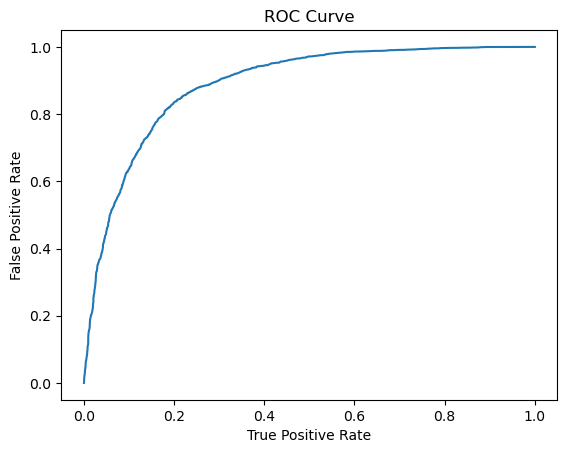

Training set areaUnderROC: 0.8877385690600346


In [18]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

we obtain a plot showing the ROC curve, which illustrates the trade-off between the true positive rate and the false positive rate. The area under the ROC curve is a performance metric that quantifies the overall classification performance of the logistic regression model.

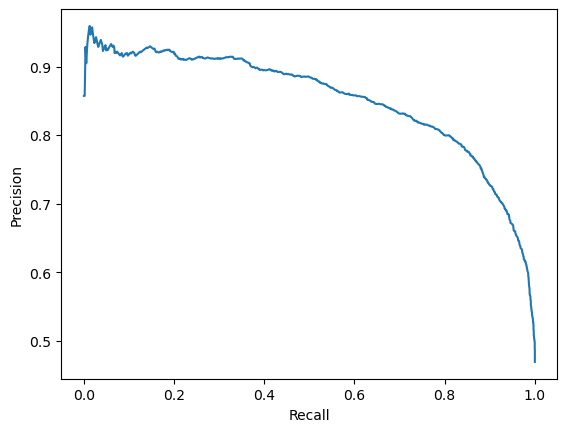

In [19]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

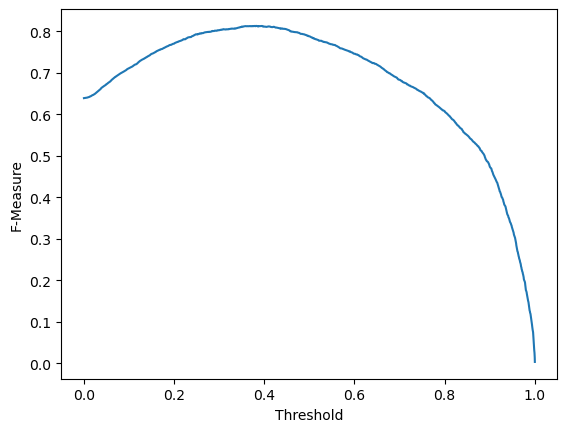

In [20]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [21]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518128...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472097...|       0.0|[0.87300981013433...|
| 52|management|  0.0|[-0.7737627890181...|       1.0|[0.31566570209267...|
| 53|management|  0.0|[0.94708137344074...|       0.0|[0.72052784002179...|
| 58|management|  0.0|[2.44657764692457...|       0.0|[0.92031082026376...|
| 32|management|  0.0|[1.28386077546037...|       0.0|[0.78310624913886...|
| 57|management|  0.0|[1.05745870556531...|       0.0|[0.74220460119091...|
| 52|management|  0.0|[3.25200815517462...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804239...|       0.0|[0.90463190417562...|
| 31|management|  0.0|[1.47121751117284...|       0.0|[0.81324237120150...|
+---+-------

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.885643189559481


as we can see from our model we can see that the model is perfoming fairly good

In [23]:
evaluator.getMetricName()

'areaUnderROC'

In the below code we will be implementing a paramGridBuilder and CrossValidator where we will also fit it and we will use it look at the perfoamce

In [24]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8844768025913865


In [25]:
evaluator.getMetricName()

'areaUnderROC'

In the above cross validation we will be looking at its perfomance and we can see that the perfomance of our original moddel and our tuned model perfomes farily the same

## We will be implementing a decision tree classifier

Decision trees are widely used sinnce they can easily interpret ,handel categorical data and extend multiclass classifications and hanldel and capture non-linearities and feature interactions

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [27]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [28]:
evaluator.getMetricName()

'areaUnderROC'

e can clearly see that our decision tree algorithm is perfom poorly .Howevwer we can improve its perfomance by using using ensemble methods such as a random Forest classifier .Uses multiple decision trees thus  abetter perfomance is expected

In [29]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[14.8827412822390...|       0.0|[0.74413706411195...|
| 49|management|  0.0|[14.5227182192155...|       0.0|[0.72613591096077...|
| 52|management|  0.0|[6.31918596967185...|       1.0|[0.31595929848359...|
| 53|management|  0.0|[13.3374319906188...|       0.0|[0.66687159953094...|
| 58|management|  0.0|[14.9217508726985...|       0.0|[0.74608754363492...|
| 32|management|  0.0|[14.2799648956826...|       0.0|[0.71399824478413...|
| 57|management|  0.0|[14.6155899979088...|       0.0|[0.73077949989544...|
| 52|management|  0.0|[16.1793896833486...|       0.0|[0.80896948416743...|
| 46|management|  0.0|[15.7414445611576...|       0.0|[0.78707222805788...|
| 31|management|  0.0|[14.8304065225174...|       0.0|[0.74152032612587...|
+---+-------

In [30]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8805183722421867


In [31]:
evaluator.getMetricName()

'areaUnderROC'

In [32]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

The perfomance when using an ensemble random feorest classifier we can see that the perfomance of our model improves.Perfoms almost similar to the logistic regression model

## GRADIENT-BOOSTED TREE CLASSIFIER

A gradient boosted tree classifier works by iteratively training a sequence of decision trees, where each subsequent tree focuses on correcting the mistakes made by the previous trees, and the final prediction is obtained by combining the predictions of all the trees through a weighted sum.

In [33]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

In [34]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8935091626908479


In [35]:
evaluator.getMetricName()

'areaUnderROC'

In [36]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8954659543871663

All in all we will sttle on  the very powerful gradient boosted tree model ,has the better perfomance but the  above notebook can be used when working with any pyspark cllassification algorithms problems(A MASTERPIECE)